In [2]:
import tkinter as tk
from PIL import Image, ImageDraw
import torch
from torch import nn
from torchvision import transforms
import matplotlib.pyplot as plt

In [3]:
device = "mps"
class NeuralNetwork(nn.Module):
  def __init__(self):
    super().__init__()
    self.flatten = nn.Flatten()
    self.linear_relu_stack = nn.Sequential(
        nn.Linear(28*28, 512),
        nn.ReLU(),
        nn.Linear(512, 512),
        nn.ReLU(),
        nn.Linear(512, 10)
    )

  def forward(self, x):
    x = self.flatten(x)
    logits = self.linear_relu_stack(x)
    return logits

model = NeuralNetwork().to(device)
model.load_state_dict(torch.load('MNIST_model.pth'))

# Set the model to evaluation mode
model.eval()

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)

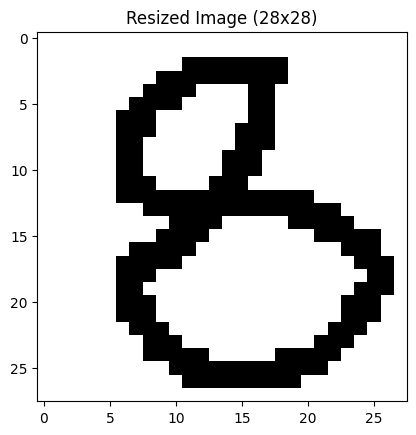

Predicted: "1"


In [16]:
class DrawCanvas(tk.Tk):
    def __init__(self):
        super().__init__()
        self.title("Draw a Digit")

        # Set the size of the drawing canvas to be larger (e.g., 280x280)
        self.canvas_size = 280
        self.grid_size = 28

        # Create a blank canvas to draw on (larger window for ease of drawing)
        self.canvas = tk.Canvas(self, width=self.canvas_size, height=self.canvas_size, bg="white")
        self.canvas.pack()

        # Set up the image for drawing (the image will be 28x28)
        self.image = Image.new("L", (self.grid_size, self.grid_size), color=255)  # 28x28
        self.draw = ImageDraw.Draw(self.image)

        # Previous x, y coordinates for continuous drawing
        self.prev_x = None
        self.prev_y = None

        # Bind mouse events for drawing
        self.canvas.bind("<B1-Motion>", self.paint)

        # Add a button to predict the drawn digit
        self.predict_button = tk.Button(self, text="Predict", command=self.predict)
        self.predict_button.pack()

    def paint(self, event):
        # Draw continuously by connecting previous and current points
        # Map the canvas coordinates (larger window) to the 28x28 grid
        x = event.x * self.grid_size / self.canvas_size
        y = event.y * self.grid_size / self.canvas_size

        if self.prev_x is not None and self.prev_y is not None:
            # Draw continuous lines on the large canvas
            self.canvas.create_line(self.prev_x, self.prev_y, event.x, event.y, width=20, fill="black", capstyle=tk.ROUND, smooth=tk.TRUE)
            # Draw continuous lines on the smaller 28x28 image
            self.draw.line([self.prev_x * self.grid_size / self.canvas_size, self.prev_y * self.grid_size / self.canvas_size, 
                            x, y], fill=0, width=2)

##
# def draw_line_with_fade(self, x1, y1, x2, y2):
#       steps = 10  # Number of fading steps
#       r1, g1, b1 = self.master.winfo_rgb(self.brush_color)
#       r2, g2, b2 = r1, g1, b1 # Target color is the same as initial color

#       for i in range(steps):
#           r = int(r1 + (r2 - r1) * i / steps)
#           g = int(g1 + (g2 - g1) * i / steps)
#           b = int(b1 + (b2 - b1) * i / steps)
          
#           # Convert RGB to Tkinter color string
#           color = '#%02x%02x%02x' % (r // 256, g // 256, b // 256)
          
#           # Draw line segment with current color
#           self.canvas.create_line(x1, y1, x2, y2, width=self.line_width, fill=color, smooth=True)
##

        self.prev_x = event.x
        self.prev_y = event.y

    def predict(self):
        # Predict the digit from the drawn image
        label = self.predict_image(self.image)
        #print(f"Predicted digit: {label}")

    def predict_image(self, image):
        # Transform the image (resize to 28x28, convert to tensor, normalize)
        transform = transforms.Compose([
            transforms.Resize((self.grid_size, self.grid_size)),  # Resize the image to 28x28 (for consistency)
            transforms.Grayscale(num_output_channels=1),  # Ensure it's grayscale
            transforms.ToTensor(),  # Convert to a tensor
            transforms.Normalize((0.1307,), (0.3081,))  # Normalize (apply the same normalization as used in training)
        ])
        
        # Apply the transformation to the image and move it to the correct device
        image = transform(image).unsqueeze(0).to(device)  # Add batch dimension and move to device
        
        # Convert the tensor to a NumPy array for displaying
        image_np = image.squeeze().cpu().numpy()  # Remove batch dimension and move to CPU for display
        
        # Display the resized image using plt.imshow()
        plt.imshow(image_np, cmap='gray')
        plt.imsave("mnist_draw.png", image_np, cmap='gray')
        plt.title("Resized Image (28x28)")
        plt.show()

        classes = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
        x = torch.tensor(image_np).unsqueeze(0).to(device)
        with torch.no_grad():
            pred = model(x)
            predicted = classes[pred[0].argmax(0)]
            print(f'Predicted: "{predicted}"')

        # Make the prediction
        # output = model(image)  # Forward pass
        # _, predicted = torch.max(output, 1)  # Get the class with the highest probability
        # return predicted.item()

# Run the app
app = DrawCanvas()
app.mainloop()